# Generalized linear models: Count regression

*Gries, chapter 5.4.3 (pp. 324-327)*

Let us revisit the exercise on teenagers' submission/donation of chat conversations to a sociolinguistic research project. Instead of running a binary logistic regression (for response: 'small' vs 'large' submission), we will now try to predict the actual number of words donated. **For modeling (unbounded) counts or frequencies, we use count regression**. **Recall that a 'regular' linear model is not adequate to model counts** as its predictions can range from $-\infty$ to $+\infty$, and a negative count does not make any sense (nor do floating-point numbers). Count distributions always have a 'hard floor' at zero, as no negative counts occur. Additionally, they are guaranteed to be integers. 

The prototypical count distribution is a *Poisson distribution*, named after the French mathematician Poisson - hence the name 'Poisson regression' for the modeling of counts and frequencies. However, Poisson models do not deal well with overdispersed counts, which tend to happen a lot. The correct choice of model is a matter of some debate. For this course, *in general* we recommend that you model basic count data with Bambi using `family='negativebinomial'`, but you can always test with `family=poisson` and see if the model improves!

> MATHS: You can read more about modelling with negative binomials [in the Bambi examples](https://bambinos.github.io/bambi/notebooks/negative_binomial.html) but the short version is that negative binomial distributions have an extra parameter when compared to Poisson, which allows them to fit with longer tails. 

## Importing libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Turn off logging for NUTS sampler for PyMCMC
import logging

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

In [2]:
plt.rcParams.update(
    {"mathtext.default": "regular", "figure.dpi": 300, "figure.figsize": (8, 8)}
)

In [3]:
rng = np.random.default_rng(seed=42)

## Loading and inspecting the data

## Removing Outliers

**We stress that it is heavily debated whether or not such outliers should be deleted prior to Poisson regression.** While some argue that you should delete outliers as they may have a too strong influence on the modeling, others argue that outliers in Poisson distributions are really not that bad (compared to other distributions), and that all 'valid' datapoints should just be kept in. 

Here, to illustrate once more the procedure of deleting outliers, we show you how to delete them, but in the end we run all the analysis on the full data. A good exercise would be to compare the results on the cut data.

A widely applied cutoff to delete outliers, is to delete items that are 1.5 times or more the interquartile range (IQR) above the third quartile, and 1.5 times or more the IQR below the first quartile.

In [4]:
chat = pd.read_csv("../../datasets/chat/chat.tsv", sep="\t")

iqr = chat.nr_tokens.quantile(0.75) - chat.nr_tokens.quantile(0.25)
cut = chat.nr_tokens.quantile(0.75) + iqr * 1.5

chat_cut = chat[chat.nr_tokens < cut]
print(f"{chat.shape[0]- chat_cut.shape[0]} observations removed.")
chat_cut

185 observations removed.


nr_tokens  subject_ID  gender   education  emoticons  nonstd_Dutch
0          1487           1    male     general         49           292
1          1859           2    male   technical         49           298
2           178           3    male     general          0            32
3           258           4  female     general          0            53
4            48           5    male  vocational          0             3
...         ...         ...     ...         ...        ...           ...
1379        287        1380  female   technical          4            68
1380        407        1381  female   technical         25            66
1381        613        1382  female     general          1            96
1382       1657        1383  female  vocational         74           410
1383        322        1384    male     general          0            54

[1199 rows x 6 columns]

## Run the model

The only change we need is to specify the model family - here it is `family=negativebinomial`

In [5]:
model = bmb.Model(
    "nr_tokens ~ gender",
    chat,
    family="negativebinomial",
)
idata = model.fit(
    target_accept=0.9,
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=False,
)
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha         0.380  0.012   0.358    0.402      0.000    0.000    4375.0   
Intercept     7.770  0.061   7.653    7.881      0.001    0.001    3922.0   
gender[male] -0.636  0.086  -0.804   -0.482      0.001    0.001    4279.0   

              ess_tail  r_hat  
alpha           3035.0    1.0  
Intercept       2964.0    1.0  
gender[male]    3050.0    1.0

## Check chains and posterior estimates

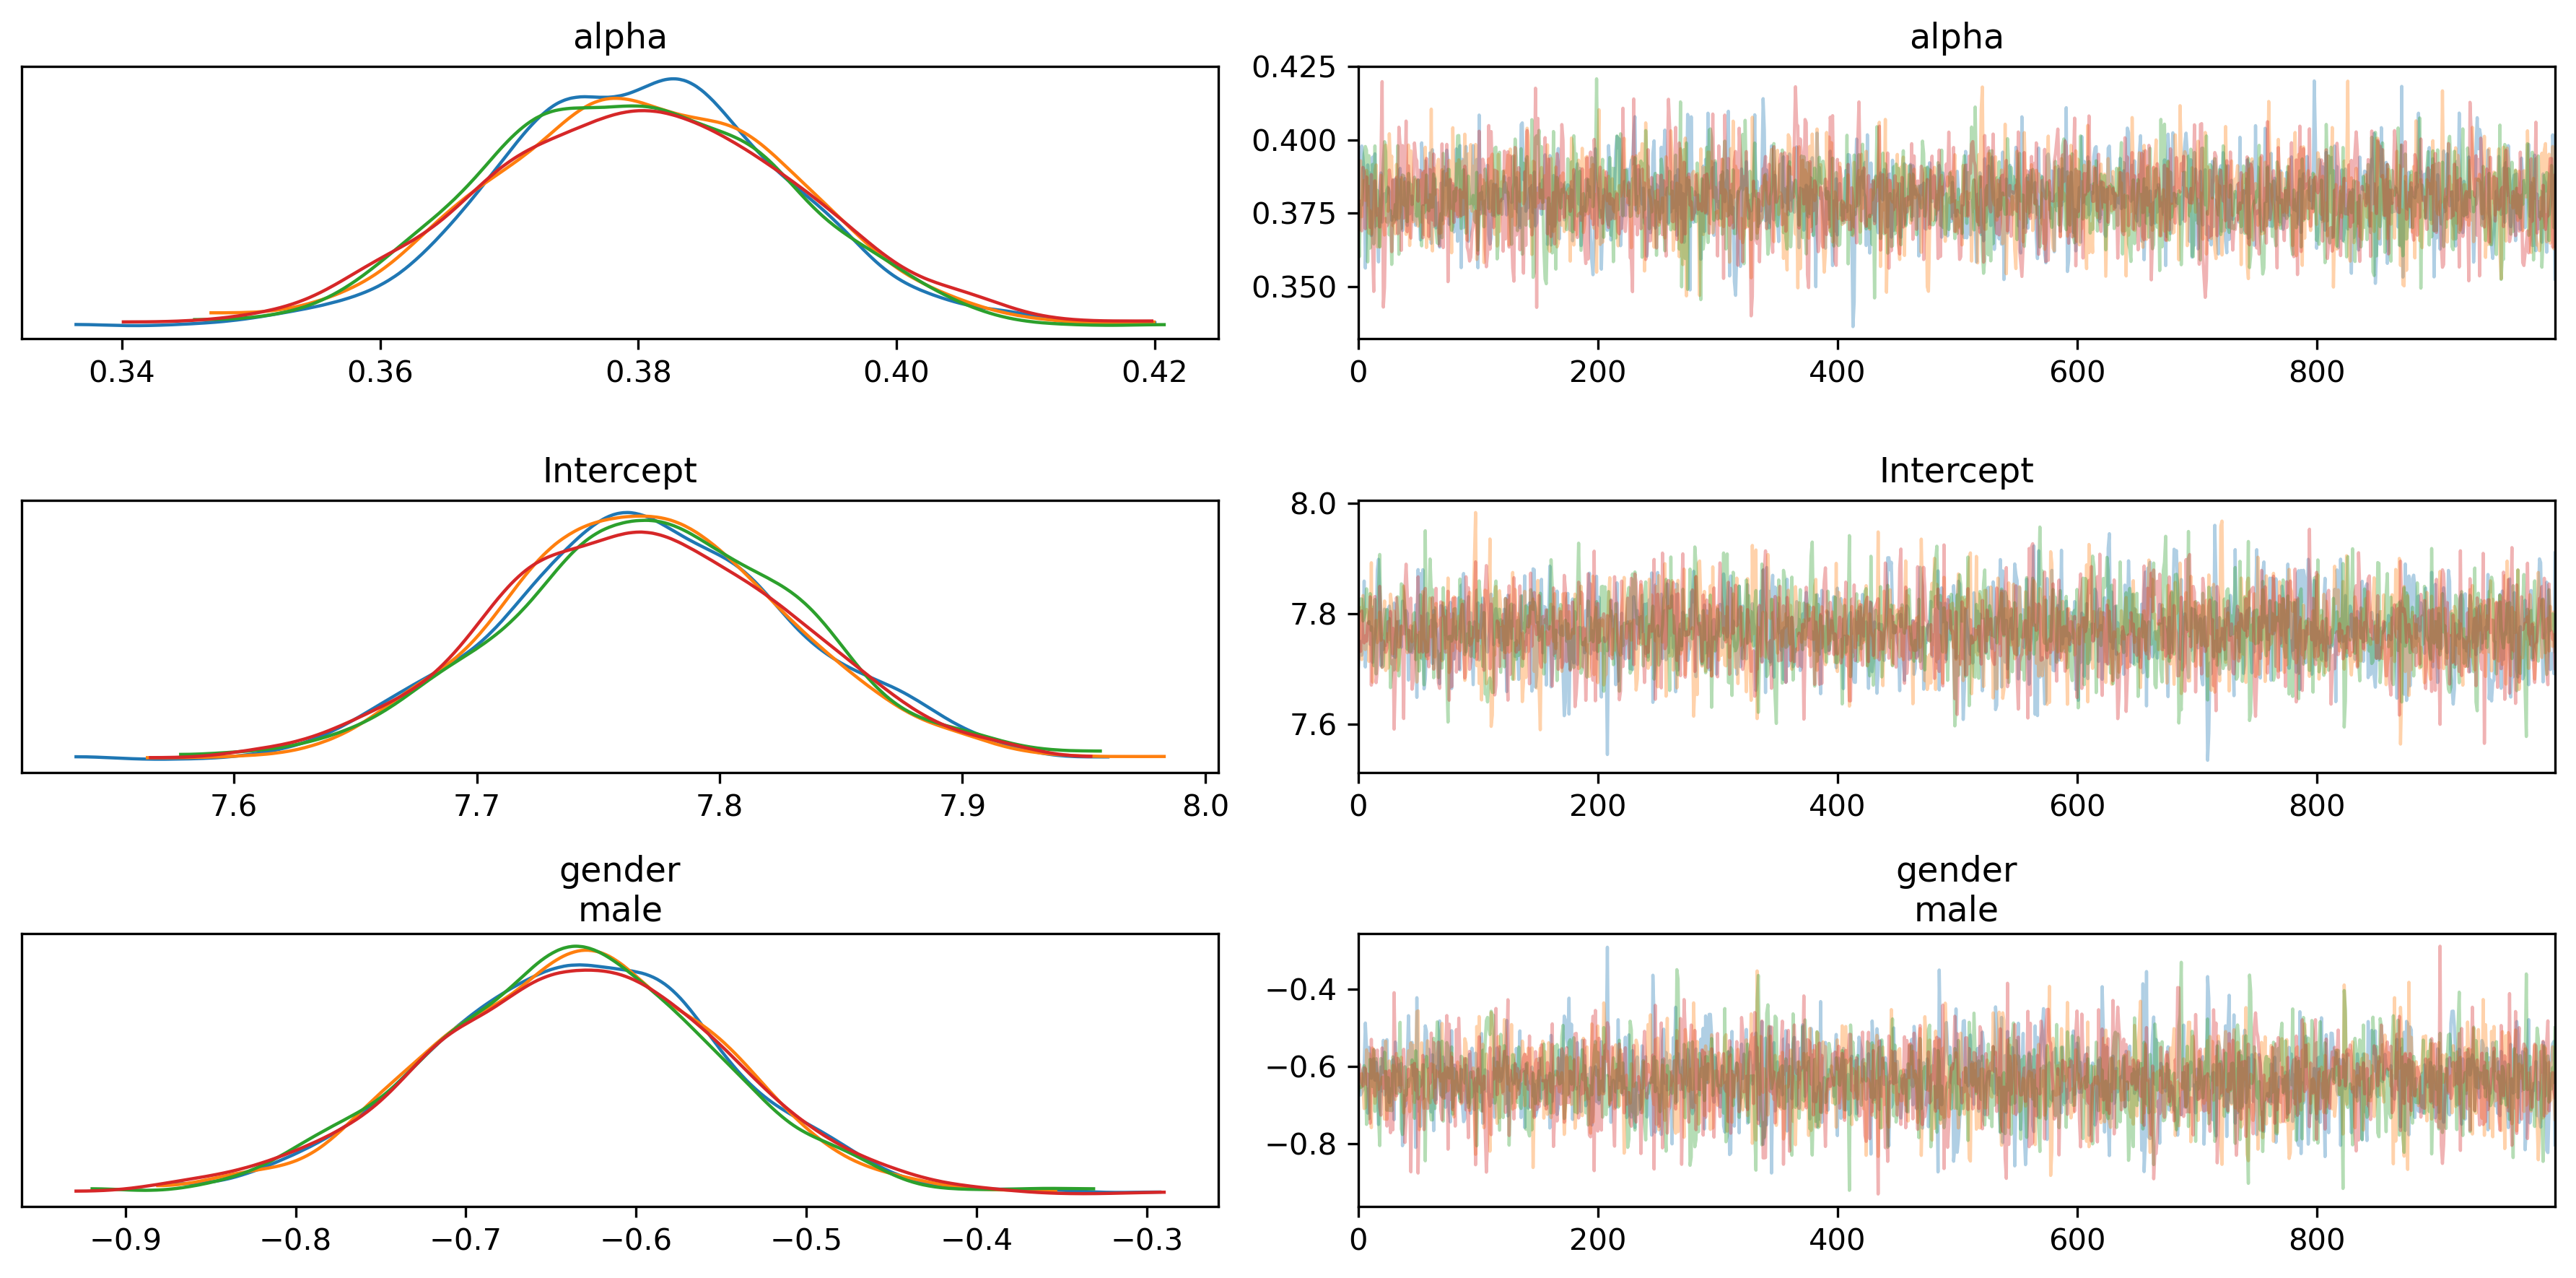

In [6]:
az.plot_trace(idata, compact=False)
plt.tight_layout()
plt.show()

## Check predicted means

Default computed for conditional variable: gender


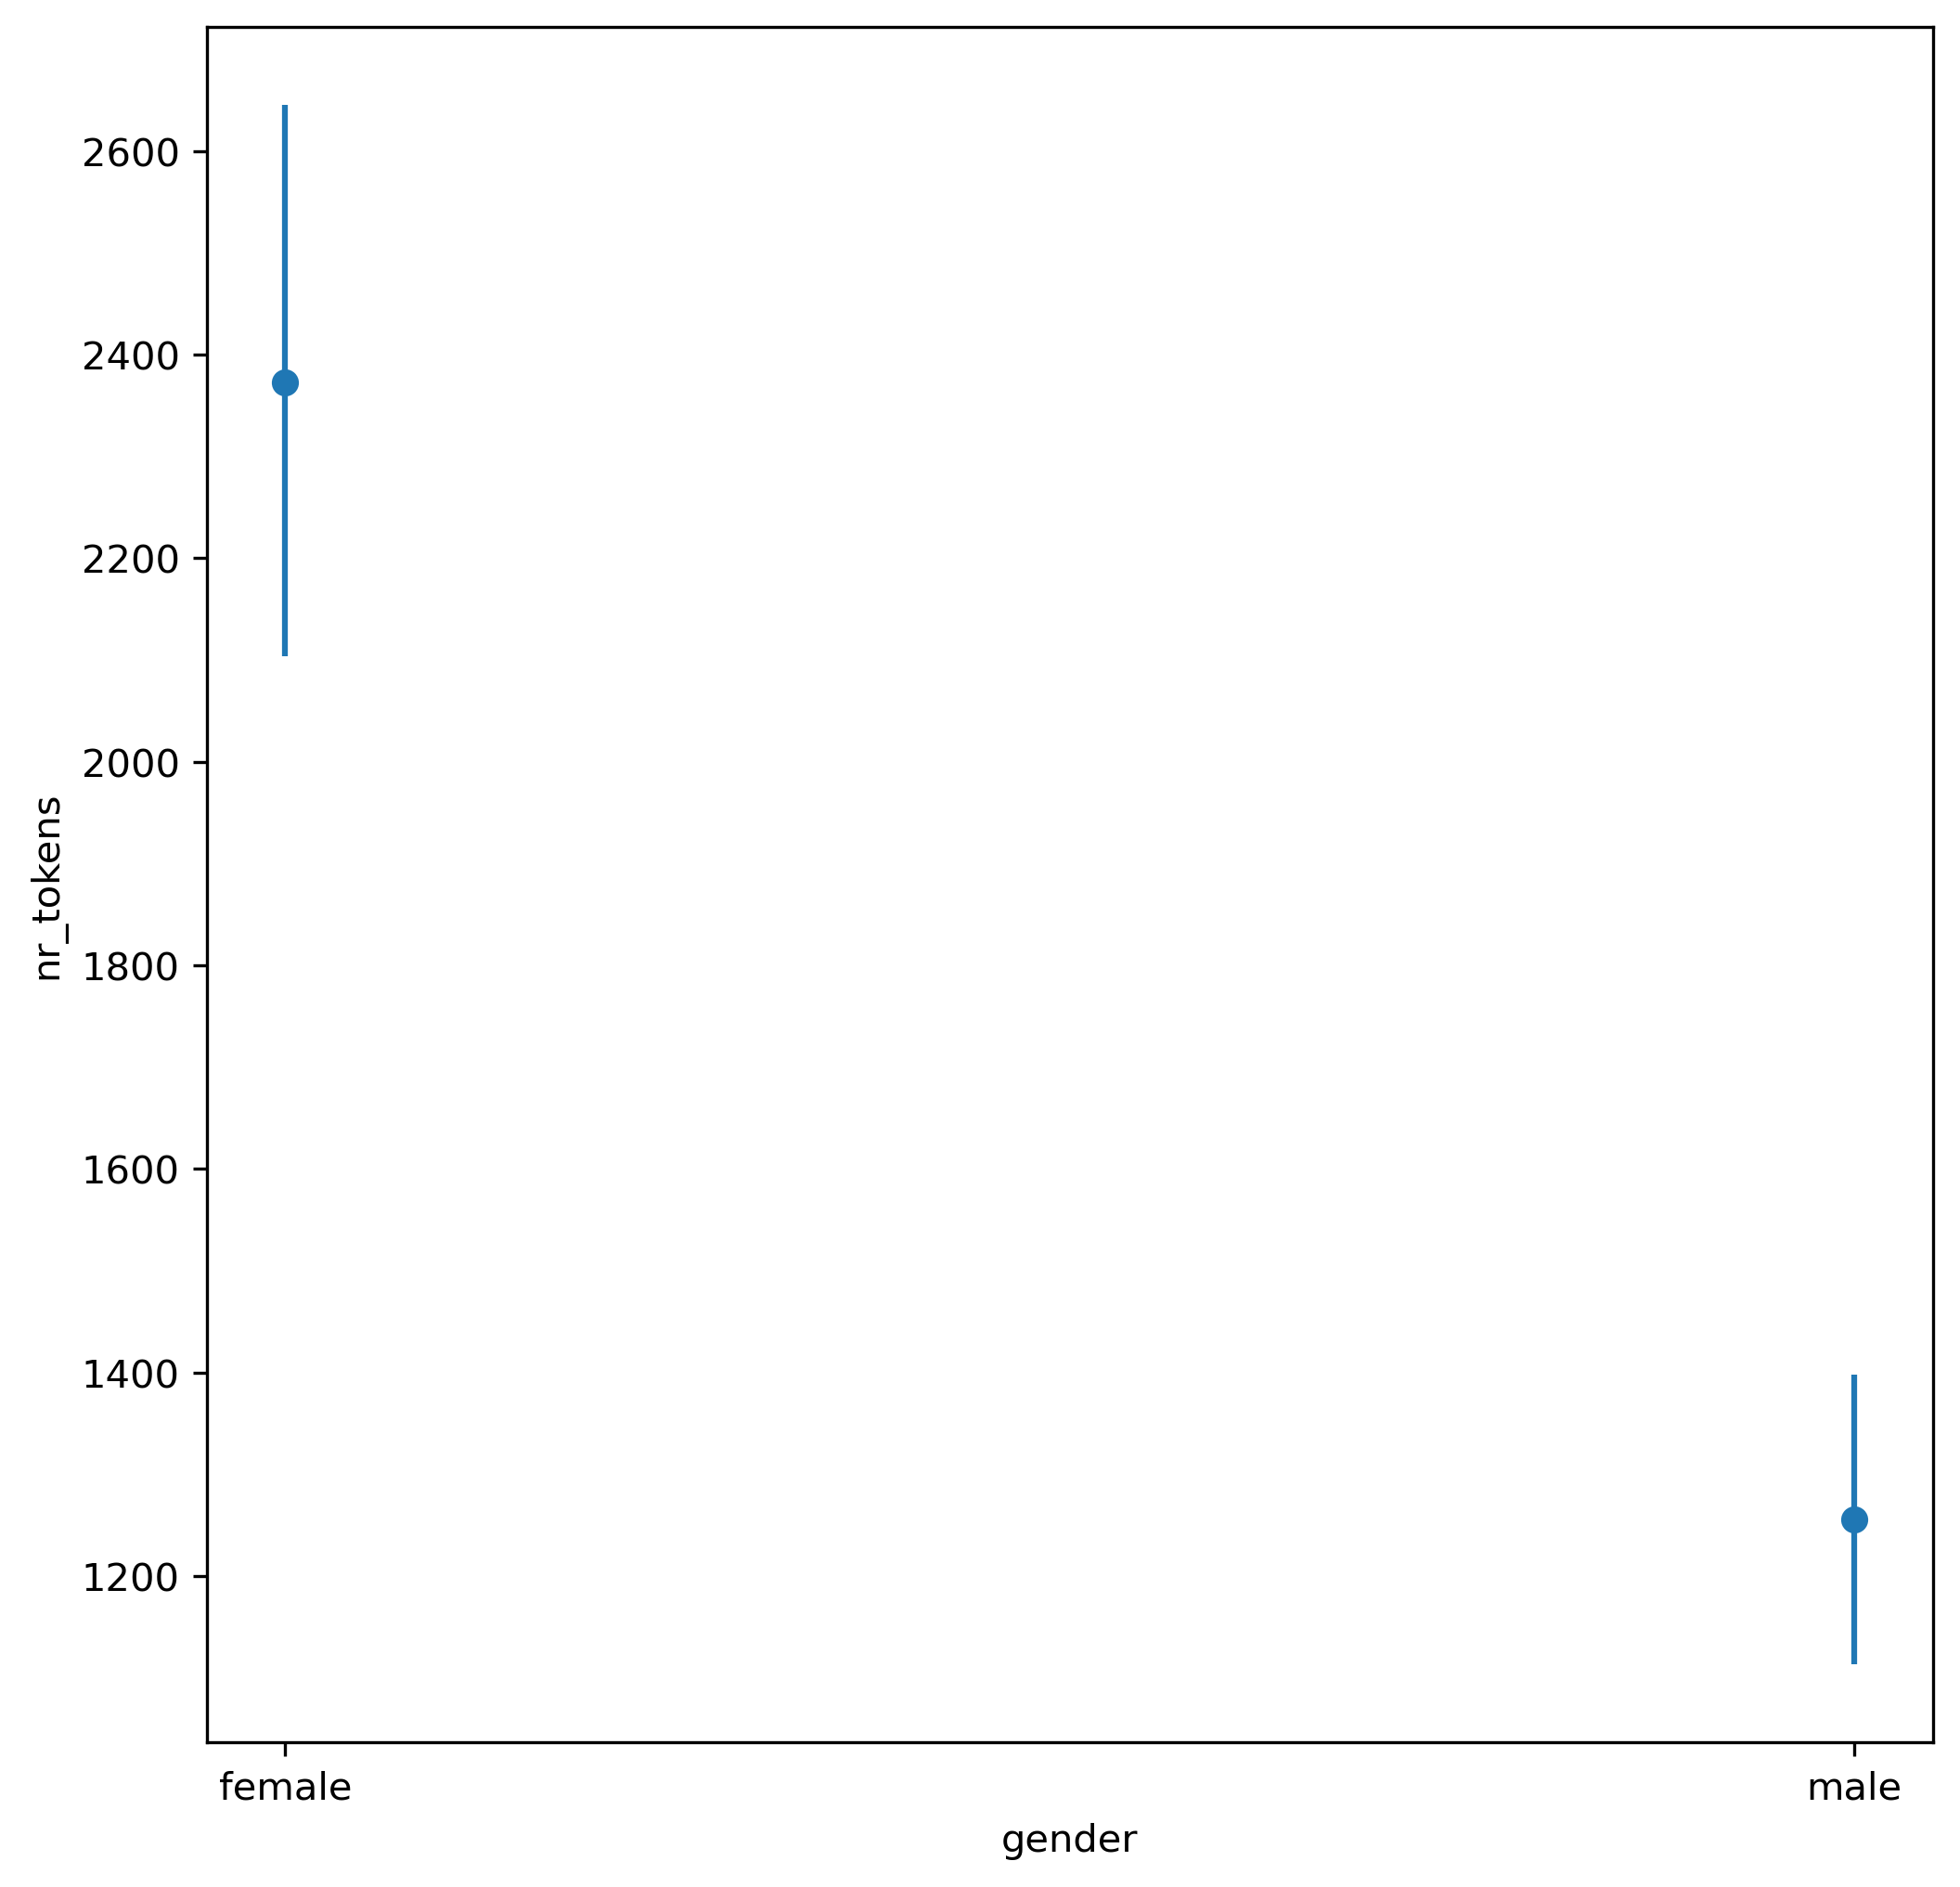

In [7]:
bmb.interpret.plot_predictions(
    model,
    idata,
    ["gender"],
    fig_kwargs={"sharey": True},
)
plt.show()

> NOTE the predicted means come from the mean estimates, which are on a log scale. The intercept (women are the base class) was 7.770, To convert log values to numbers we use `np.exp`

In [8]:
# This matches the mean prediction from the plot

np.exp(7.770)

2368.47128835535

## Check Posterior Predictive Curves

It would be good to know that our model predictions look something like the data. Here we use some complicated code, modified from the [Bambi Examples](https://bambinos.github.io/bambi/notebooks/count_roaches.html). Don't worry about the code too much. The key thing to look at is whether the `observed` curve (our real observations) falls mostly within the posterior predictive estimates (could it plausibly be predicted by the model).

The predictions are occasionally very large, so here we cut some *predictions* above the 3rd Quartile to make the result easier to see. Overall, the predictions don't seem terrible. We are under-predicting for low token counts, but not drastically. Note that we did NOT remove outliers from the observations, the "cutting" here is only so we can see the curve fitting at the low end where most of the observations lie.

In [9]:
def plot_posterior_ppc(model, idata, cut=False):
    # plot posterior predictive check
    id = model.predict(idata, kind="response", inplace=False)
    var_name = "nr_tokens"
    # there is probably a better way
    ppd = id.posterior_predictive["nr_tokens"]
    obs = id.observed_data["nr_tokens"]
    if cut:
        id.posterior_predictive[var_name] = ppd.where(ppd < cut, drop=True)
        id.observed_data[var_name] = obs.where(obs < cut)
    else:
        id.posterior_predictive[var_name] = ppd
        id.observed_data[var_name] = obs

    return az.plot_ppc(id, var_names=[var_name])

<Axes: xlabel='nr_tokens'>

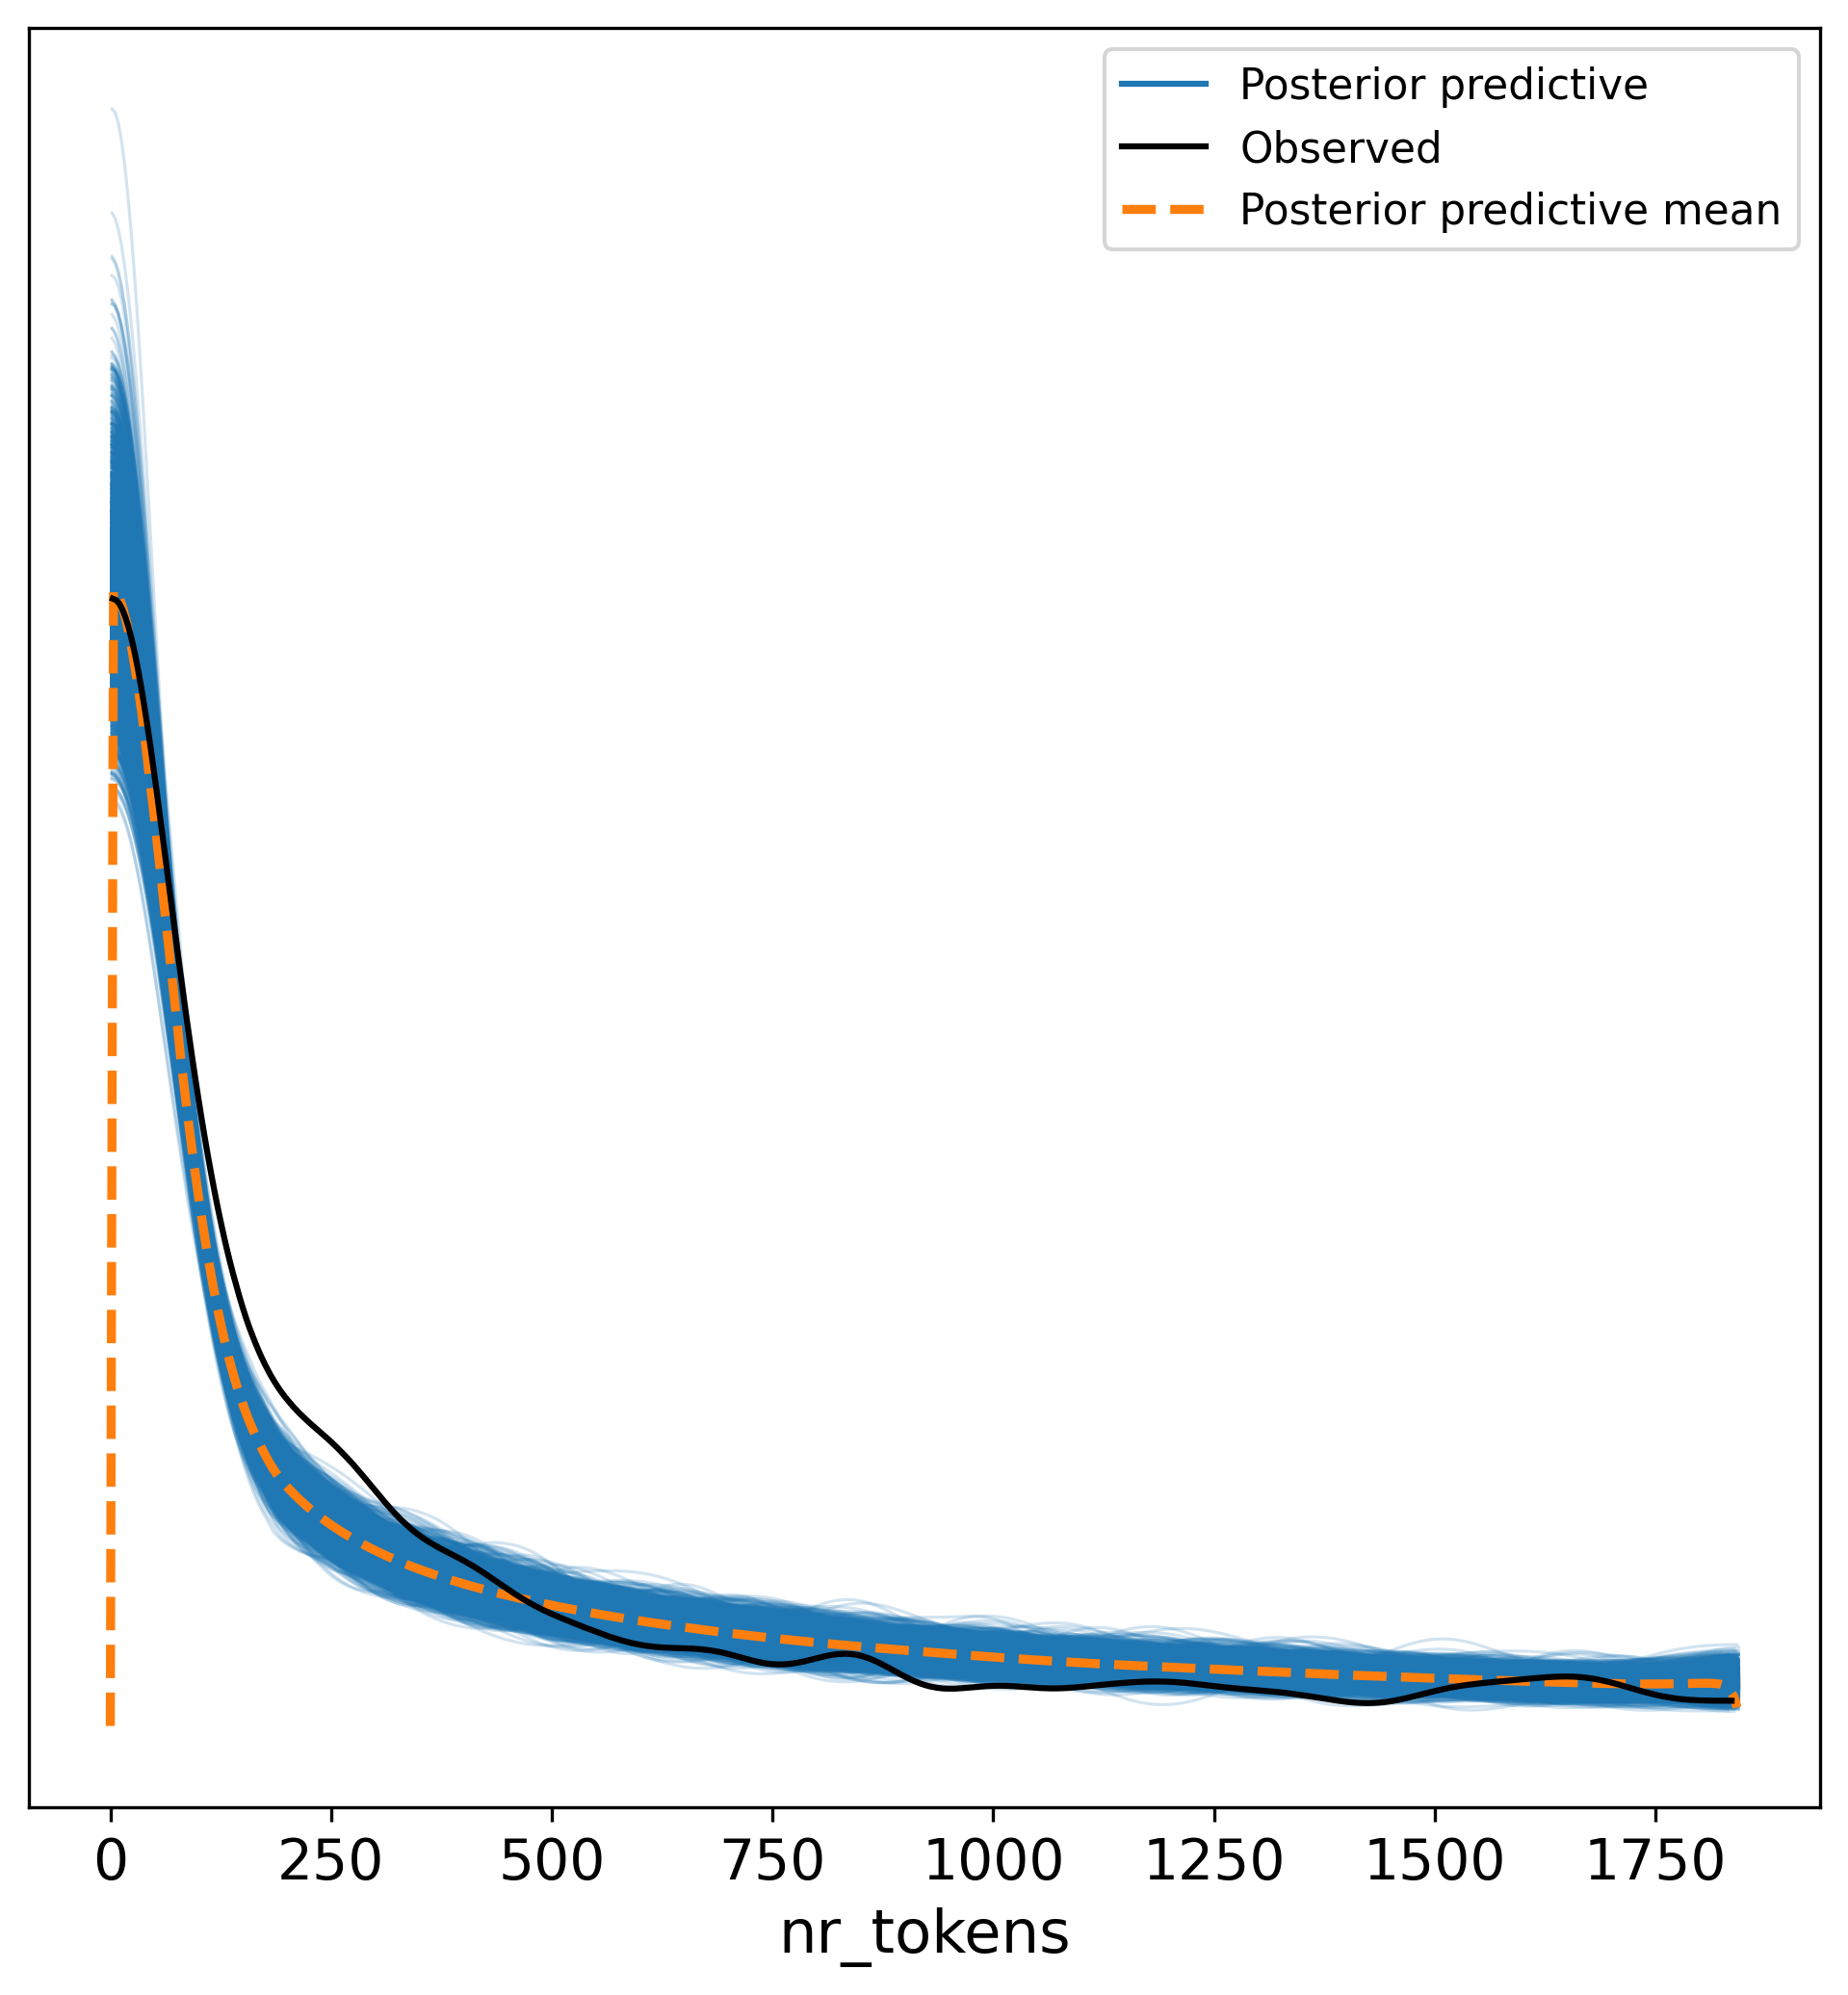

In [10]:
# You can increase the quantile value to see the fit on more of the observations

plot_posterior_ppc(model, idata, cut=chat.nr_tokens.quantile(0.8))

## Running a model with education terms

We can add categorical predictors just as easily...

In [11]:
model_education = bmb.Model(
    "nr_tokens ~ gender + education",
    chat,
    family="negativebinomial",
)
idata_education = model_education.fit(
    target_accept=0.9,
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=False,
)
az.summary(idata_education)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                  0.393  0.012   0.369    0.415      0.000    0.000   
Intercept              7.382  0.076   7.232    7.520      0.001    0.001   
gender[male]          -0.652  0.086  -0.807   -0.488      0.001    0.001   
education[technical]   0.874  0.105   0.667    1.061      0.002    0.001   
education[vocational]  0.280  0.103   0.074    0.462      0.002    0.001   

                       ess_bulk  ess_tail  r_hat  
alpha                    4620.0    2862.0    1.0  
Intercept                4506.0    3287.0    1.0  
gender[male]             4811.0    2941.0    1.0  
education[technical]     4047.0    2548.0    1.0  
education[vocational]    4008.0    3033.0    1.0

Default computed for conditional variable: gender, education


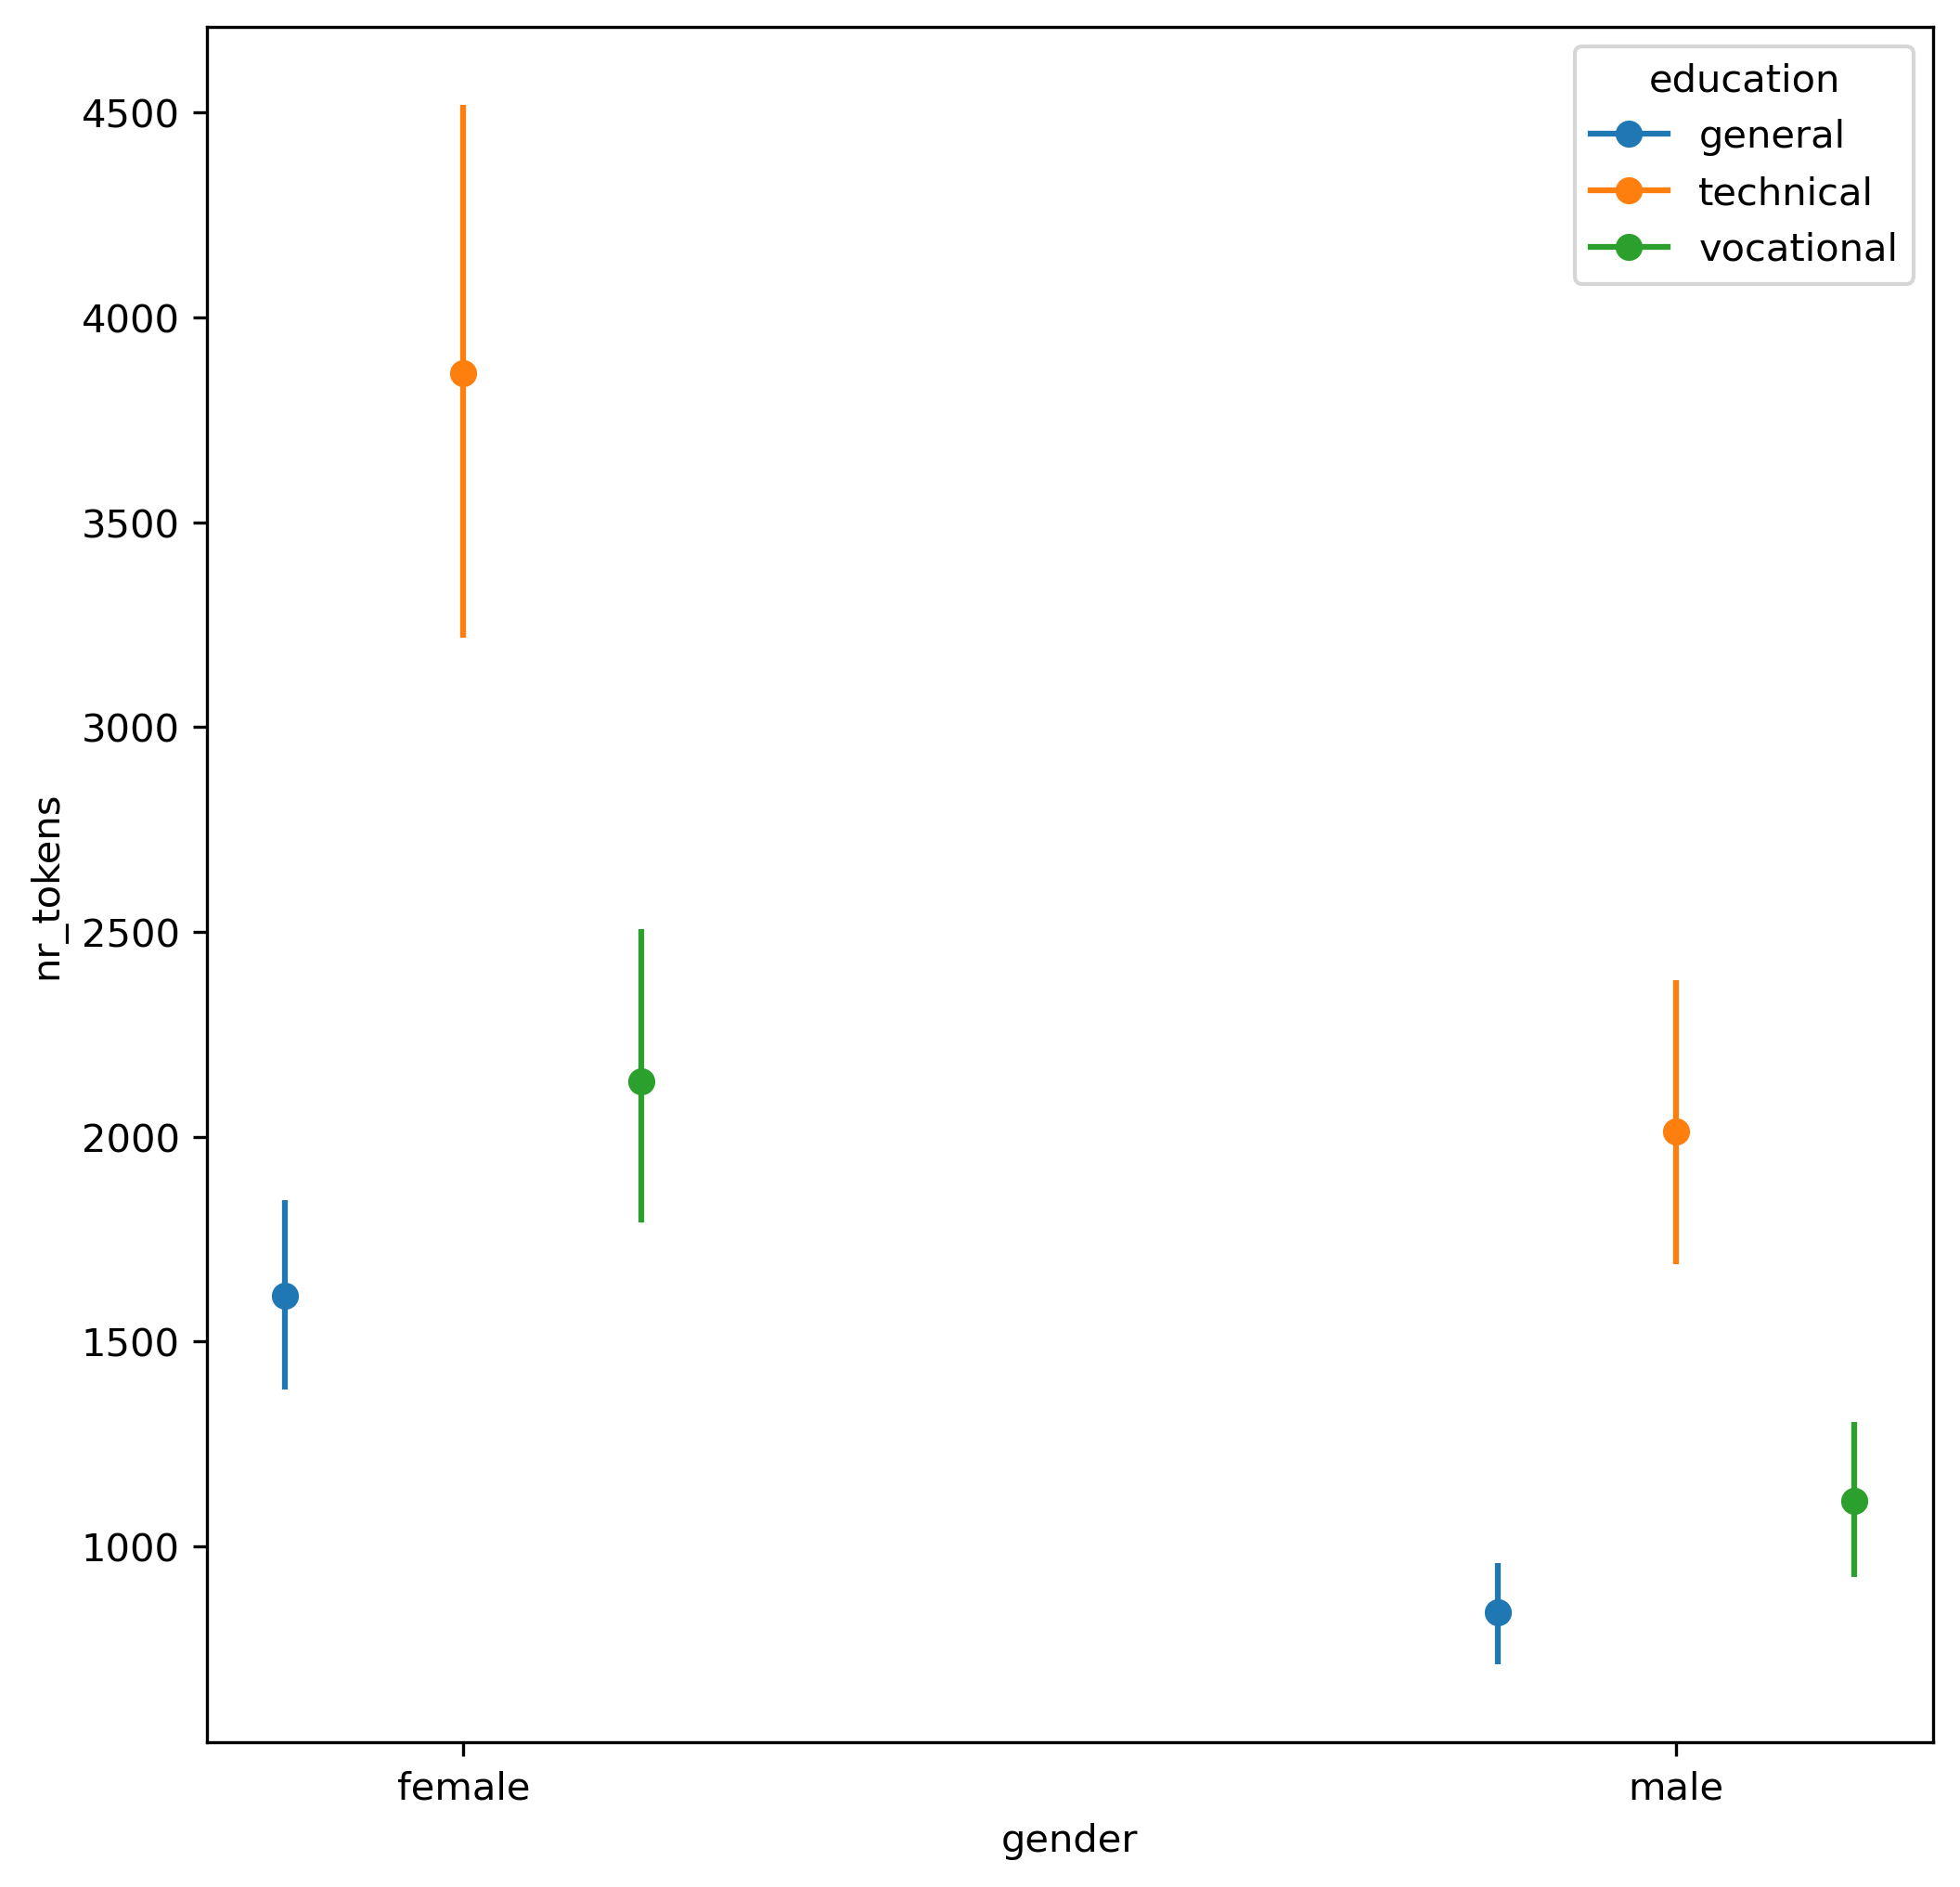

In [12]:
bmb.interpret.plot_predictions(
    model_education,
    idata_education,
    ["gender", "education"],
    fig_kwargs={"sharey": True},
)
plt.show()

## Checking for interaction effects

In [13]:
model_interaction = bmb.Model(
    "nr_tokens ~ gender * education",
    chat,
    family="negativebinomial",
)
idata_interaction = model_interaction.fit(
    target_accept=0.9,
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=False,
)
az.summary(idata_interaction)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha                               0.393  0.012   0.370    0.416      0.000   
Intercept                           7.353  0.090   7.198    7.531      0.002   
gender[male]                       -0.588  0.134  -0.841   -0.335      0.003   
education[technical]                0.896  0.145   0.635    1.169      0.003   
education[vocational]               0.370  0.146   0.102    0.643      0.003   
gender:education[male, technical]  -0.048  0.212  -0.453    0.343      0.005   
gender:education[male, vocational] -0.180  0.212  -0.592    0.190      0.005   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
alpha                                 0.000    4586.0    2958.0    1.0  
Intercept                             0.001    1895.0    2439.0    1.0  
gender[male]                          0.002    1580.0    2272.0    1.0  
education[technical]                  0.002    1840.0    2020.0    1.0  
education[vocational]                 0.002    1956.0    2458.0    1.0  
gender:education[male, technical]     0.004    1558.0    2123.0    1.0  
gender:education[male, vocational]    0.004    1535.0    2314.0    1.0

> QUESTION: What do you think? Are the modelled interaction effects significant?

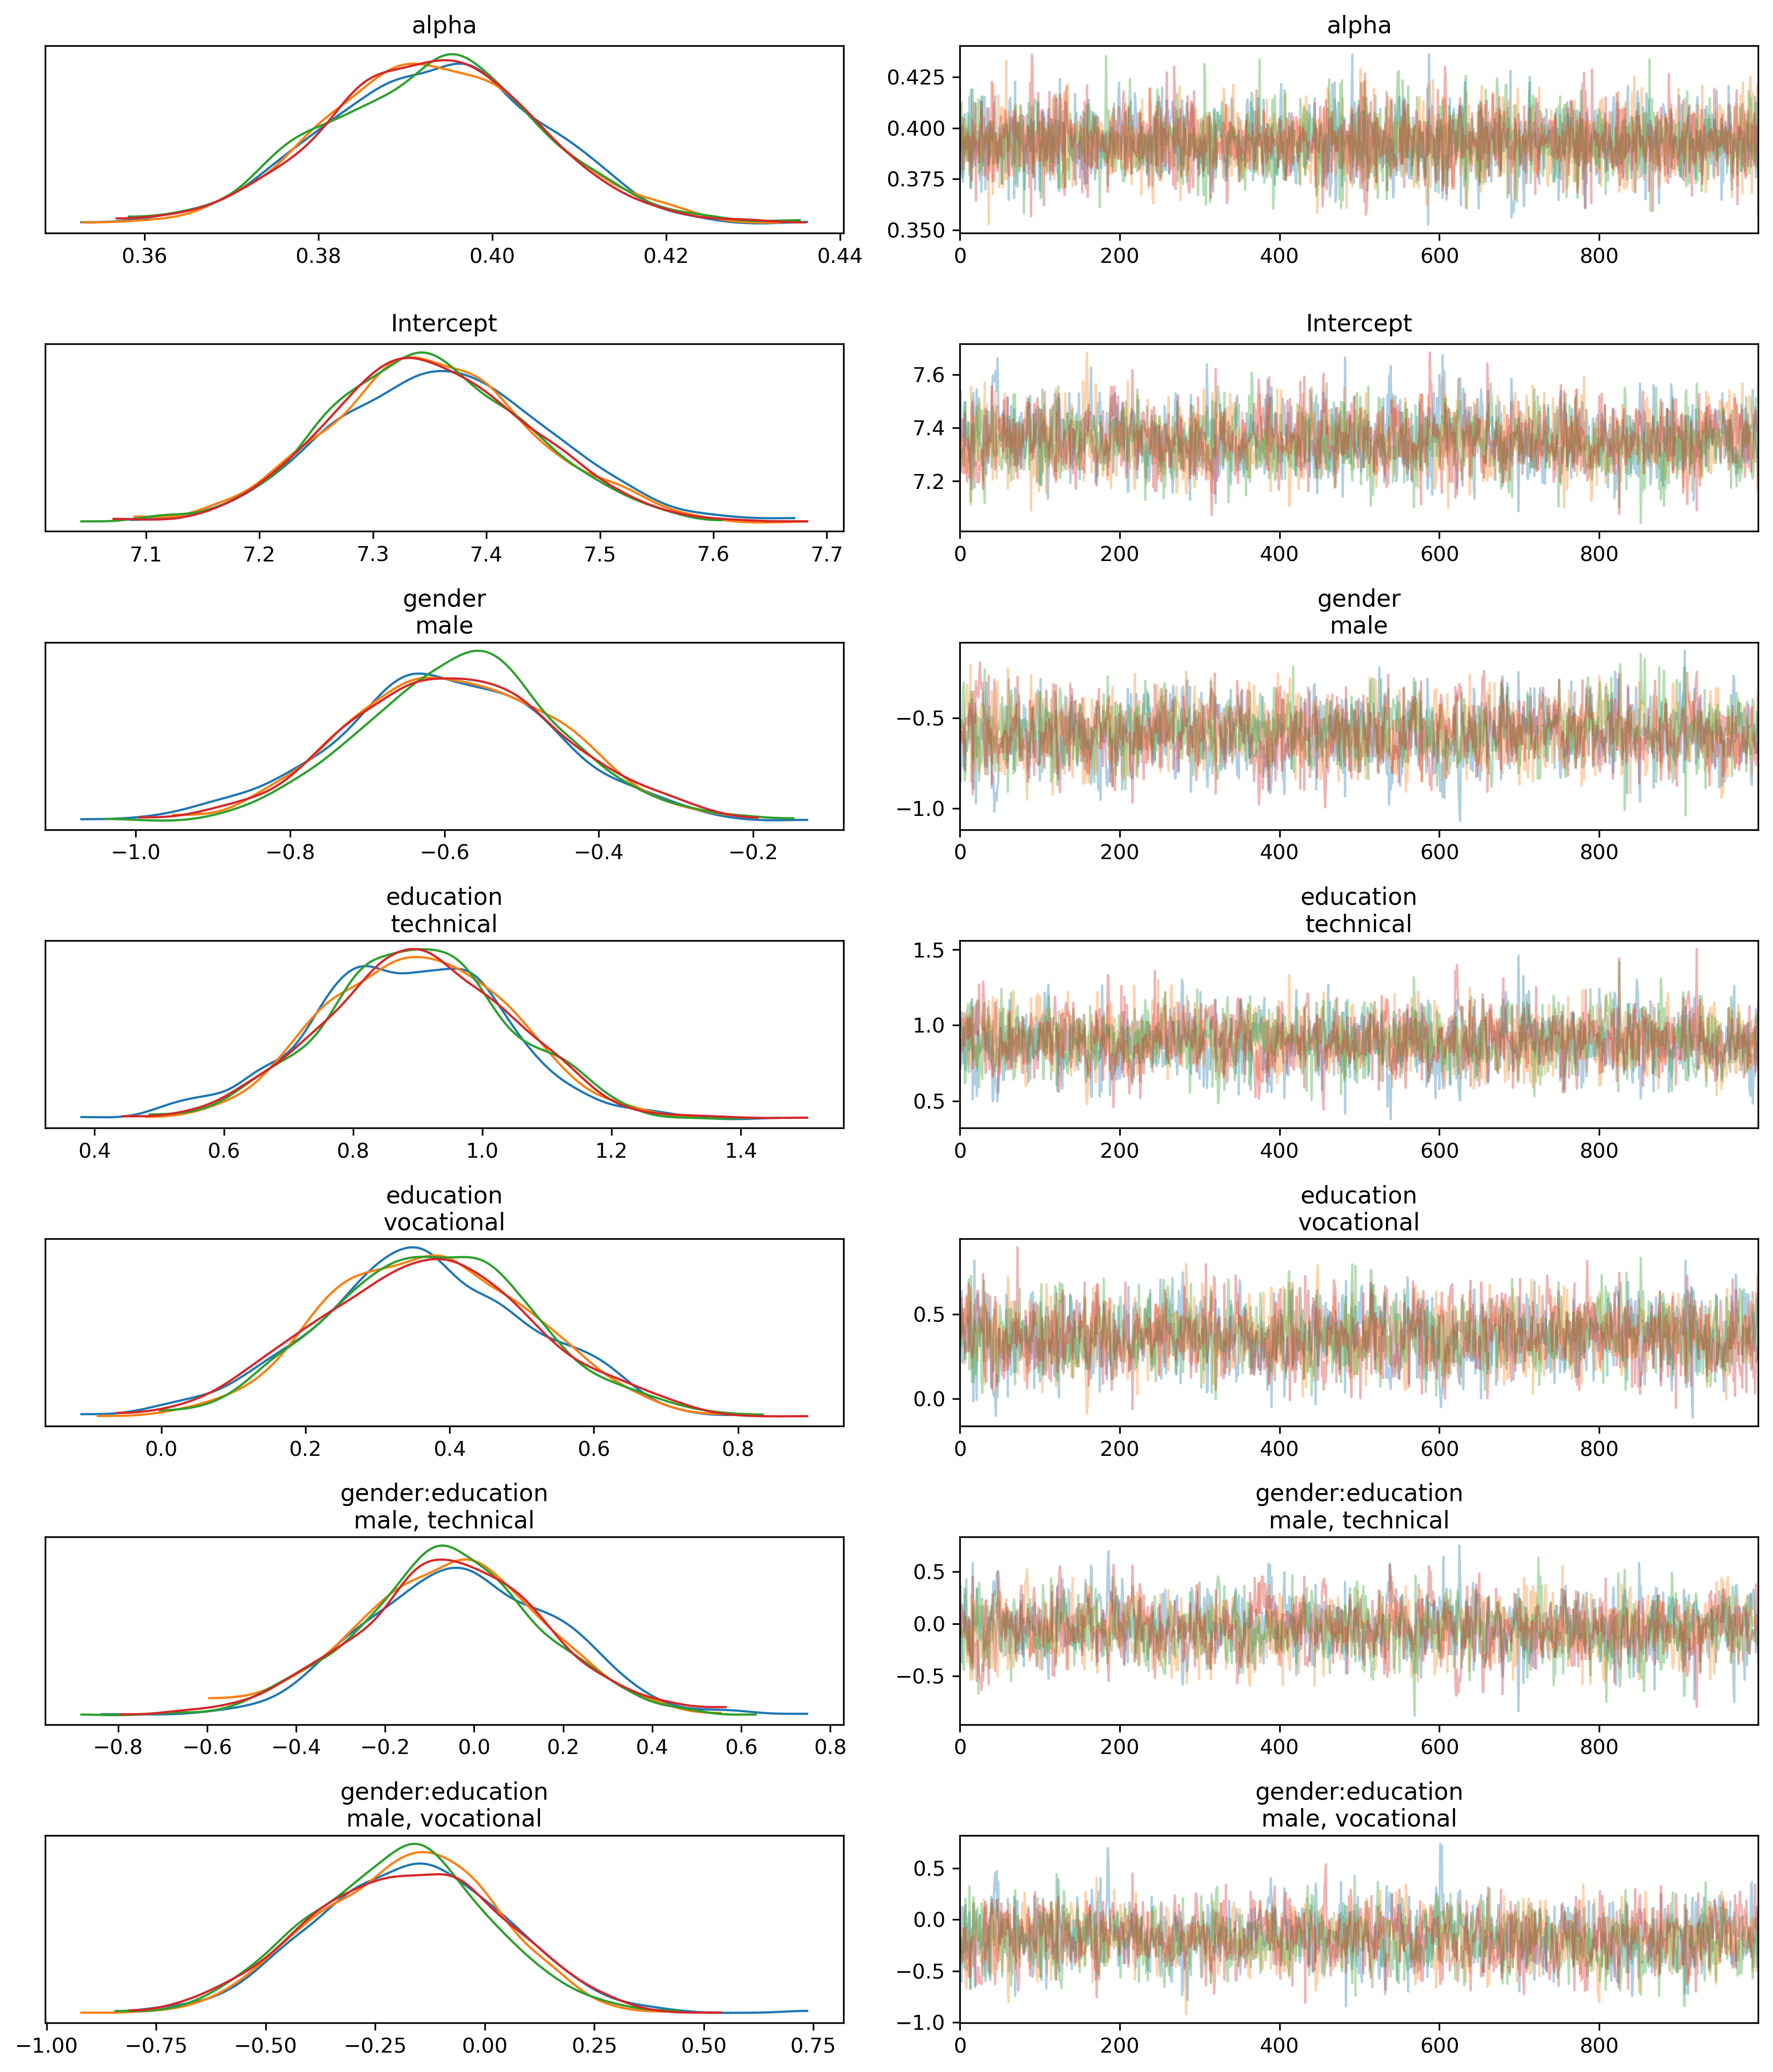

In [14]:
az.plot_trace(idata_interaction, compact=False)
plt.tight_layout()
plt.show()

Default computed for conditional variable: gender, education


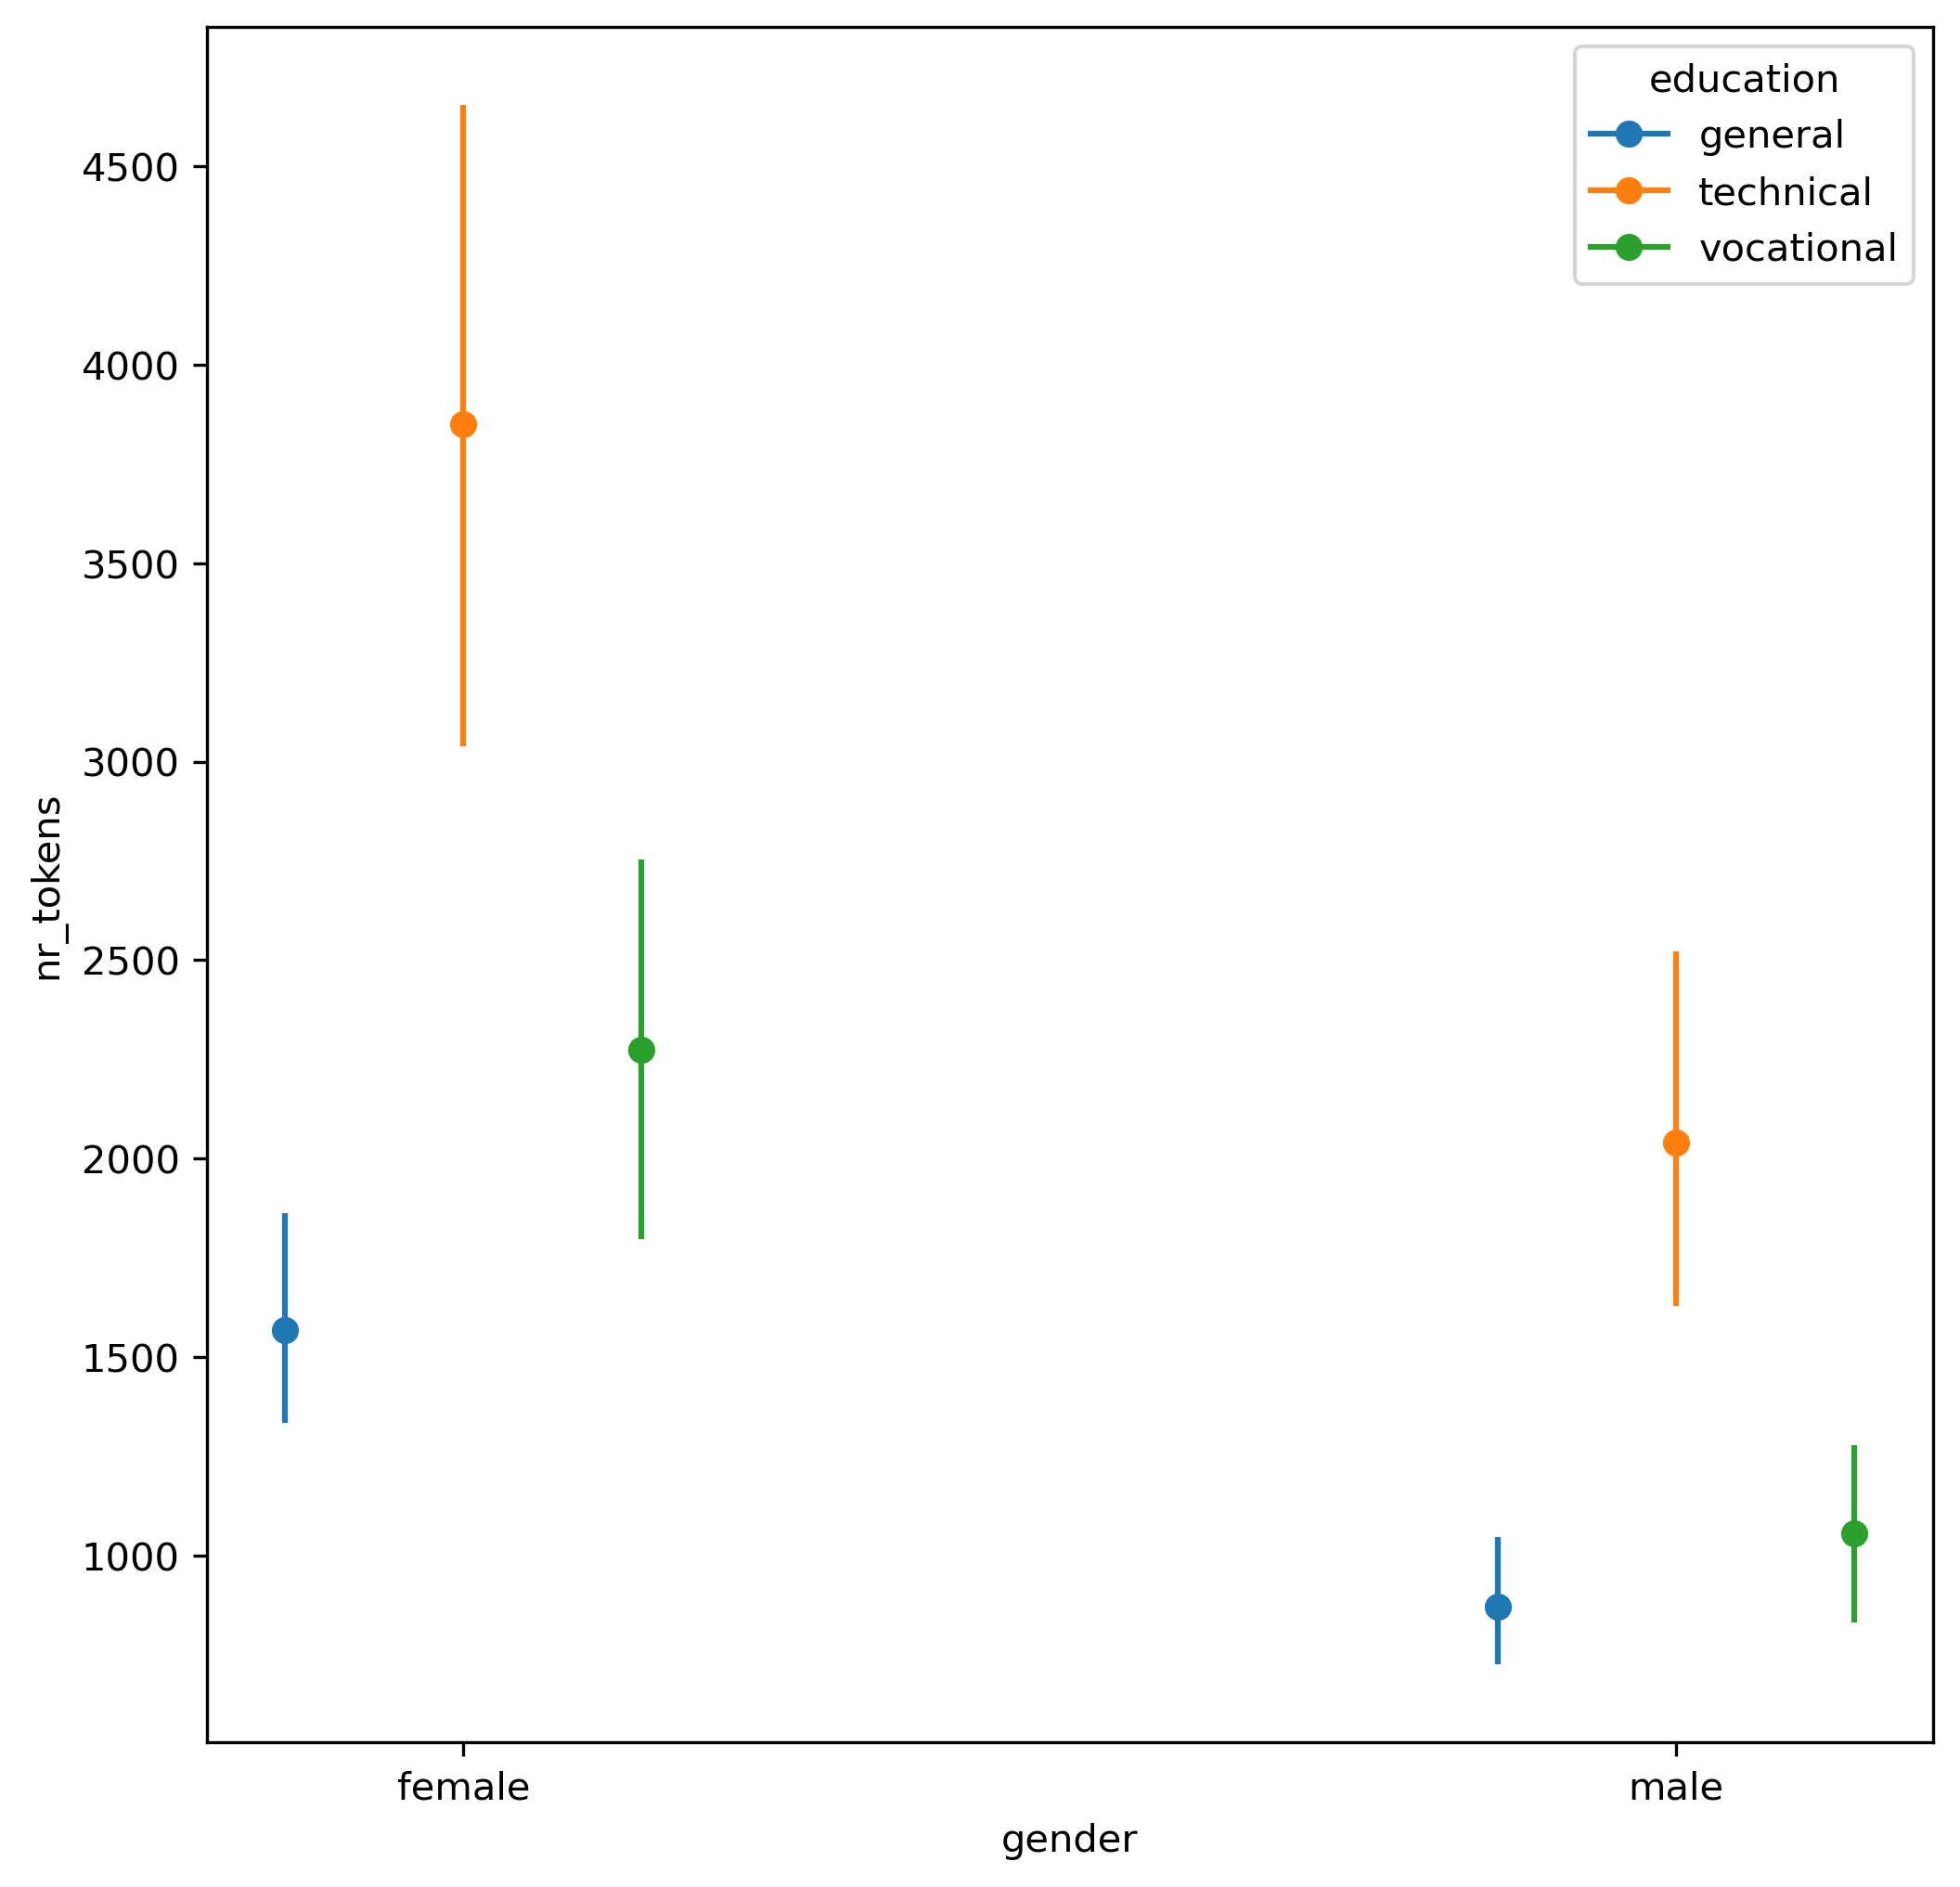

In [15]:
bmb.interpret.plot_predictions(
    model_interaction,
    idata_interaction,
    ["gender", "education"],
    fig_kwargs={"sharey": True},
)
plt.show()

## The failure of the Poisson model

> NOTE CAREFULLY that a model can still produce reasonable *mean* estimates, and (correctly) decide that effects are real while still doing a terrible job of modelling. We illustrate that here by using a Poisson model on the (massively overdispersed) data and then looking at the posterior predictive distributions.

> In Bayesian statistics, the output is THE WHOLE DISTRIBUTION, not a point estimate

In [16]:
model_poisson = bmb.Model(
    "nr_tokens ~ gender + education",
    chat,
    family="poisson",
)
idata_poisson = model_poisson.fit(
    target_accept=0.9,
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=False,
)
az.summary(idata_poisson)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              7.369  0.001   7.367    7.371        0.0      0.0   
gender[male]          -0.654  0.001  -0.656   -0.651        0.0      0.0   
education[technical]   0.881  0.001   0.878    0.884        0.0      0.0   
education[vocational]  0.307  0.002   0.304    0.311        0.0      0.0   

                       ess_bulk  ess_tail  r_hat  
Intercept                3108.0    2931.0    1.0  
gender[male]             3309.0    3142.0    1.0  
education[technical]     3079.0    3032.0    1.0  
education[vocational]    3257.0    3092.0    1.0

<Axes: xlabel='nr_tokens'>

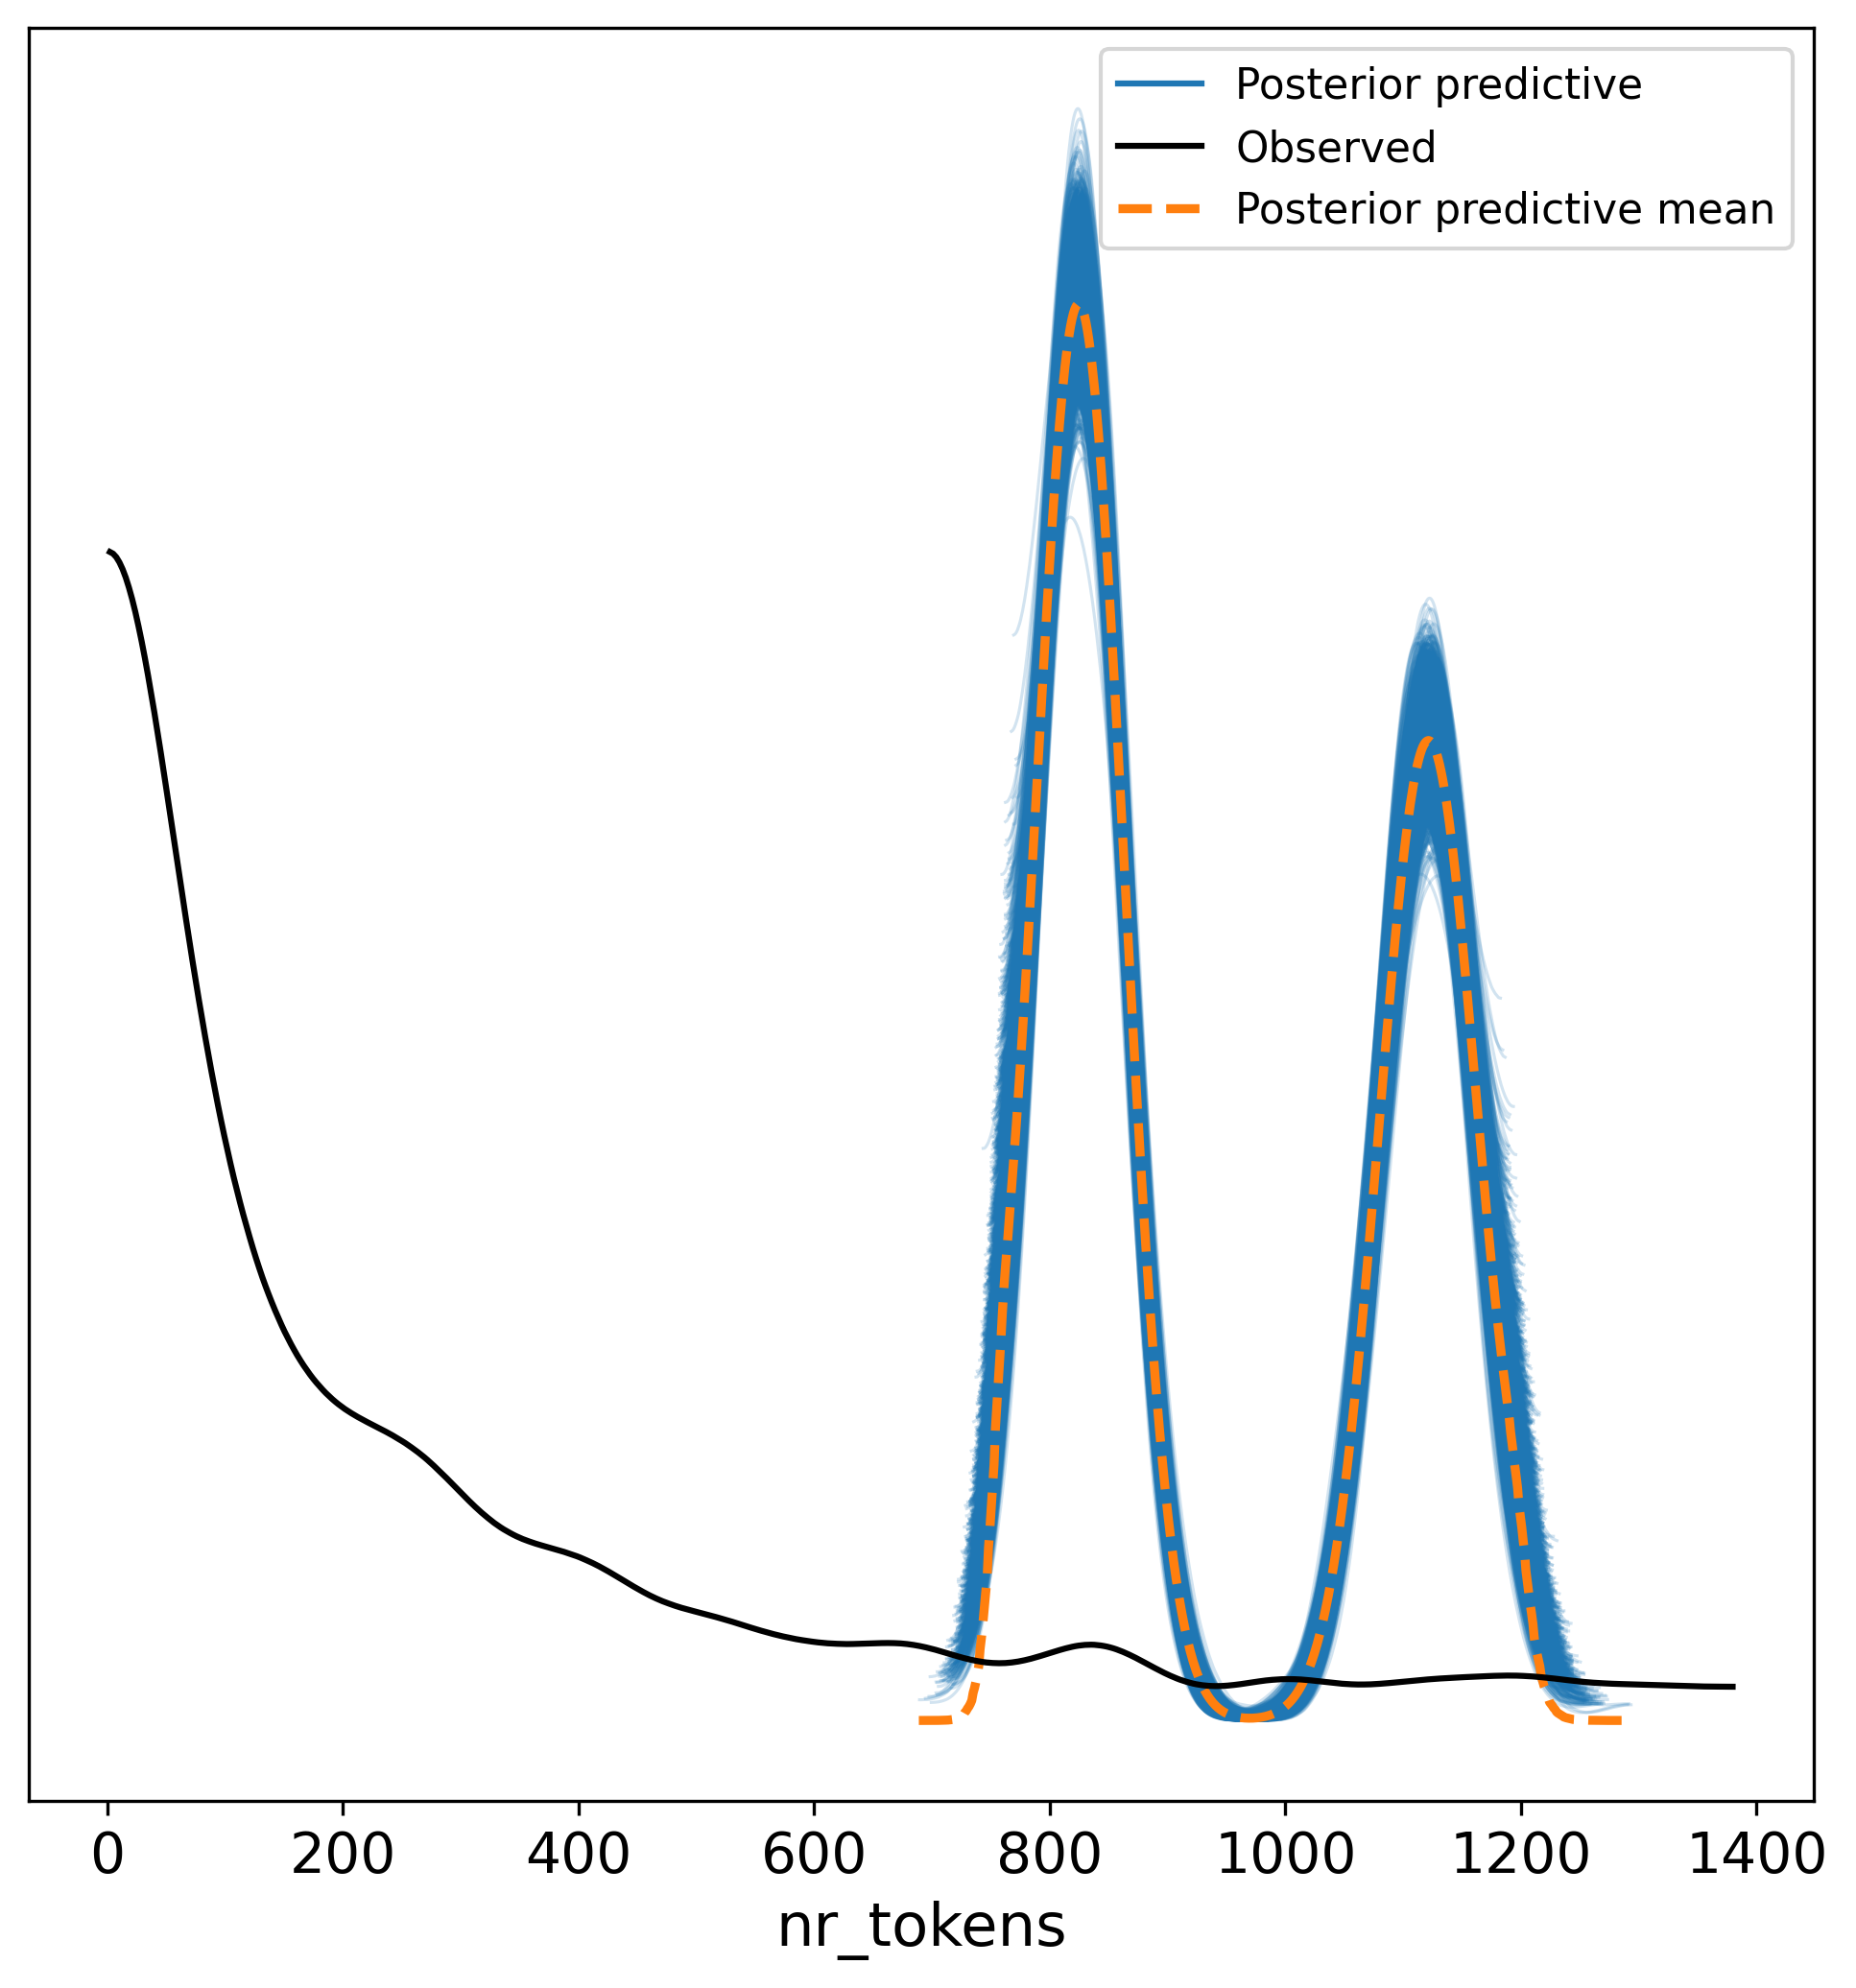

In [17]:
plot_posterior_ppc(model_poisson, idata_poisson, cut=chat.nr_tokens.quantile(0.75))

## Comparing models

Finally, we look at the ELPD of the three negative binomial models. As we saw, the interaction effects are not useful, and so we see that the `gender * education` model is a little weaker than the `gender + education` model. This conflicts with what we saw with the logistic models, by the way, and it is probably because the very long tail makes it hard for the model to accurately detect the education interaction effect. You could try eliminating `nr_tokens` outliers above 3Q + 1.5*IQR and see what happens...

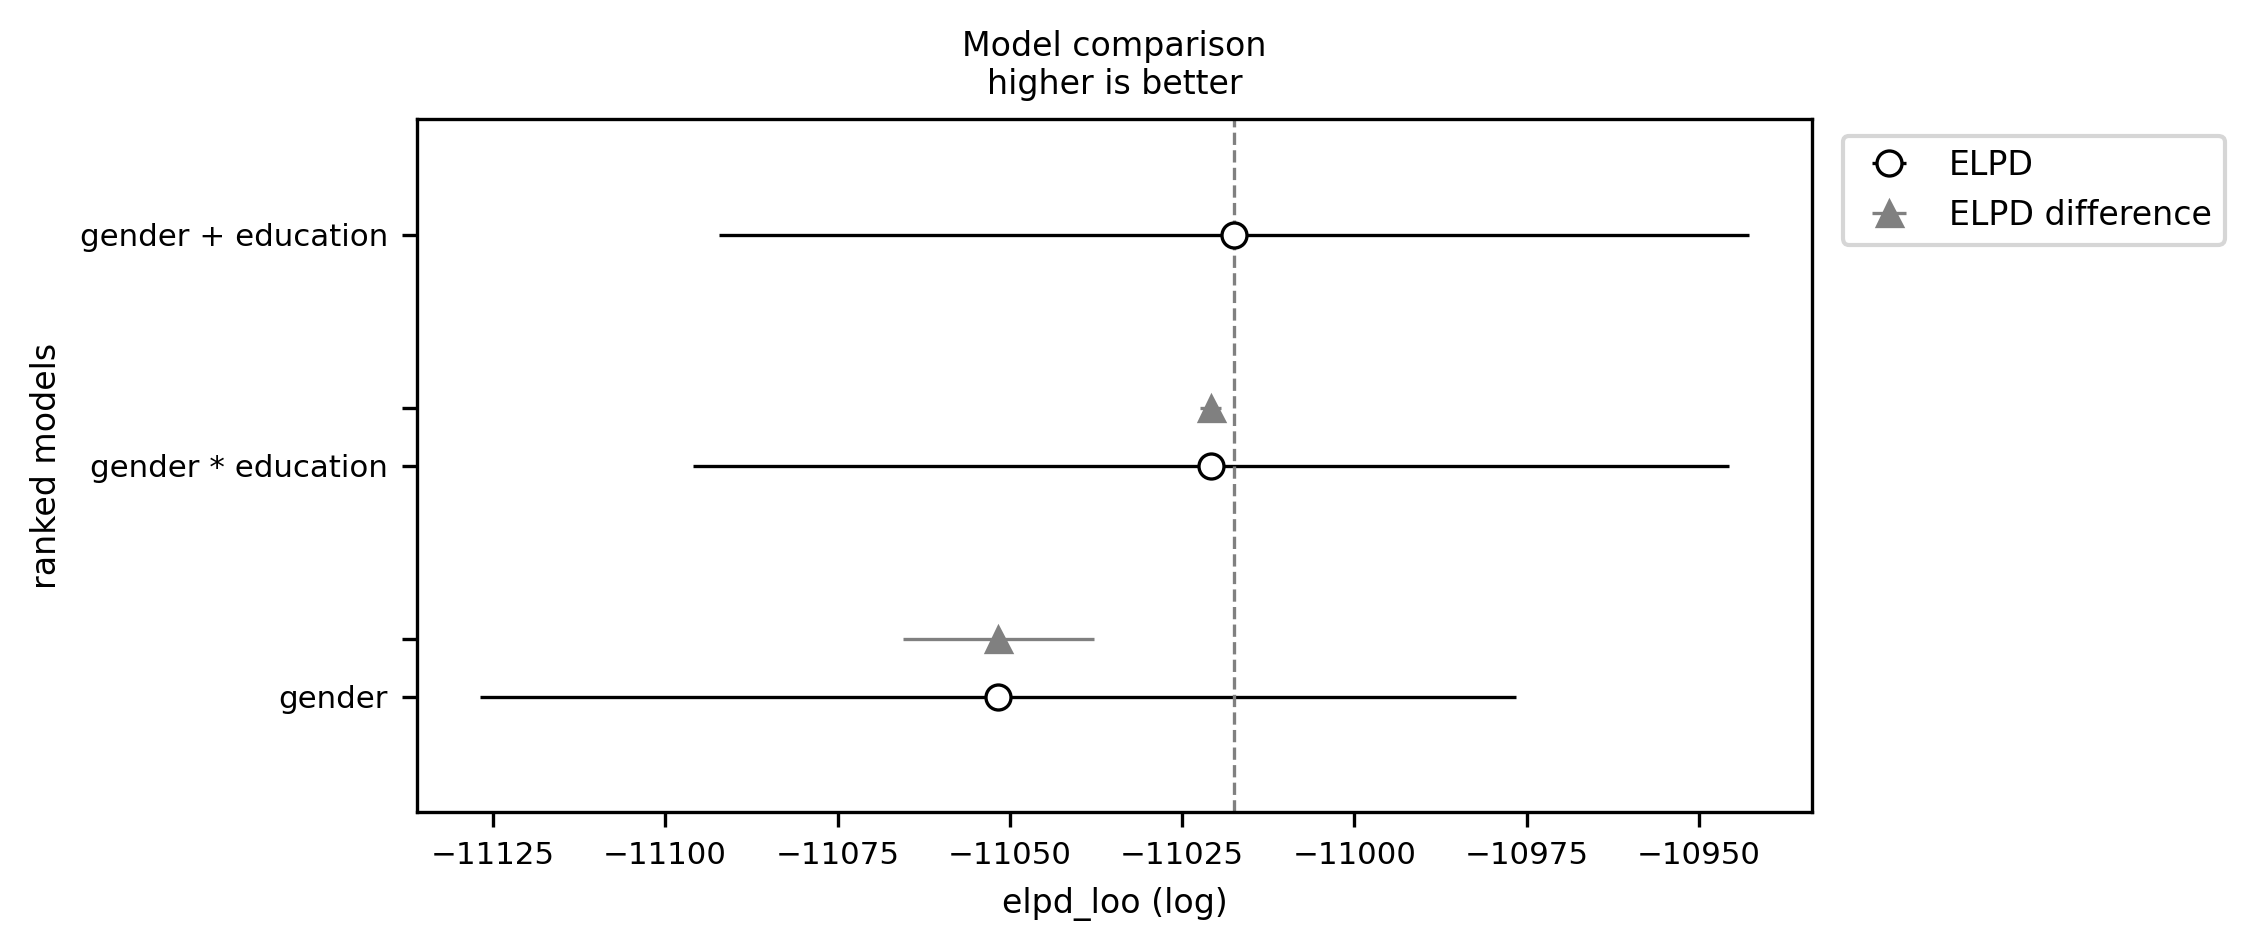

In [18]:
comp = az.compare(
    {
        "gender": idata,
        "gender + education": idata_education,
        "gender * education": idata_interaction,
    }
)
az.plot_compare(comp)
plt.show()

```
Version History

Current: v1.0.0

17/11/24: 1.0.0: first draft, BN
```